<a href="https://colab.research.google.com/github/ysooch0819/AI16-Projects/blob/main/Section2_project%EC%A4%80%EB%B9%84_Day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
# import requests
# import time
# import json
# from pandas import json_normalize

In [5]:
import sys

if "google.colab" in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    # !pip install --upgrade xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 215 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.1 MB/s 
     |████████████████████████████████| 133 kB 31.2 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=cbe6bdade0a3306956c3dbf5e9e6052cdfb10a49d89dfdbcaba9b11a3e2417bc
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 re

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# 'info' 안의 'participants' 특성에 해당 게임의 경기에서 8명의 전체유저들이 플레이한 기록이 들어있다.
# 관심있는것은 각 유저들의 해당 경기의 placement(최종순위)가 어떻게 되었는가이다.
# TFT의 랭크게임은 8명의 유저 중 최종 순위 1~4위까지는 tier 점수가 오르고, 5~8위는 tier 점수가 깎이는 방식으로 진행된다.
# 알고 싶은 것은 유저들이 게임 내 어떠한 선택지를 골랐을 때 tier(점수)를 쉽게 올릴 수 있을까? 것이므로, 게임별 상위 4명의 데이터와 하위 4명의 데이터를 별도로 분석한다.
# 필요하다면 Grandmaster, master 의 데이터도 소량 가져와야한다.

In [ ]:
# 하루에 2~3판을 플레이하는 유저에게 가장 안정적인 티어덱은 무엇인가?
# target = 'placement'

In [ ]:
### 컬럼 의미 파악
## TFT는 플레이어 피 100으로 시작, 매 전투 패배 시 승리한 상대방에게 일정 데미지를 받음, 누적되어 피가 0 이되면 게임 종료. 최후의 생존자가 1등. 1~4위는 +랭크점수 / 5~8위는 -랭크점수
# augments : 유저가 선택한 증강체, json리스트, 중요 컬럼1
# companion : 전설이(유저의 3인칭 컨트롤러), 사용X
# gold_left : 경기 종료시점에 보유한 골드량(쓰지못한 돈)
# last_round : 플레이어의 마지막 라운드, target과 직접 관계있음(당연히 마지막 라운드까지 생존한 유저가 1등 or 2등/3등), 사용X
# level : 경기 종료시점의 덱 레벨(배치 가능한 유닛 수)
# placement : 경기 최종 순위 <- 예측하려는 target
# players_eliminated : 막타 쳐서 보낸 유저의 수
# puuid : 유저의 내부식별아이디(고유값)
# time_eliminated : 플레이어의 경기 총 플레이타임(초), target과 직접 관계있음(당연히 마지막 라운드까지 생존한 유저가 플레이타임이 길다), 사용X
# total_damage_to_players : 플레이어의 전설이에게 준 데미지
# traits : 유저가 사용한 시너지조합, json 리스트, 중요 컬럼2
# units : 유저가 사용한 유닛조합, json 리스트, 중요 컬럼3

In [147]:
## EDA 80% 끝, 앞으로 여기서부터 시작
df = pd.read_csv('eda_80%_complete.csv')
df.shape

(53400, 17)

In [122]:
df.head()

,augment1,augment2,augment3,level,units,gold_left,total_damage_to_players,players_eliminated,placement,main_synergy,main_synergy_score,total_synergy_score,num_activated_synergy,cost_sum,high_cost_sum,high_cost_ratio,finals
0,JeweledLotus,PandorasBench,LagoonEmblem,8,"[{'character_id': 'TFT7_Vladimir', 'itemNames'...",50,183,2,2,Lagoon,12,30,7,138,114,0.826087,True
1,TradeSector,FirstAidKit,CyberneticUplink2,8,"[{'character_id': 'TFT7_Rakan', 'itemNames': [...",3,38,0,7,Mystic,6,21,8,69,51,0.739130,False
2,TomeOfTraits1,PandorasBench,AxiomArc2,8,"[{'character_id': 'TFT7_Rakan', 'itemNames': [...",1,69,0,5,Ragewing,8,25,8,83,74,0.891566,False
3,CelestialBlessing2,Electrocharge1,JadeEternalProtection,8,"[{'character_id': 'TFT7_Wukong', 'itemNames': ...",1,121,0,3,Jade,21,32,7,58,43,0.741379,True
4,ShimmerscaleTrait,AxiomArc1,Ascension,9,"[{'character_id': 'TFT7_Nasus', 'itemNames': [...",3,207,2,1,Shimmerscale,21,35,8,128,116,0.906250,True


In [123]:
df.isnull().sum()

augment1                     0
augment2                    23
augment3                   249
level                        0
units                        0
gold_left                    0
total_damage_to_players      0
players_eliminated           0
placement                    0
main_synergy                 0
main_synergy_score           0
total_synergy_score          0
num_activated_synergy        0
cost_sum                     0
high_cost_sum                0
high_cost_ratio              0
finals                       0
dtype: int64

In [148]:
# augment2 와 augment3 은 게임을 진행하면서 순차적으로 선택하는 증강체이다. 고르지 못하고 그 전에 패배하는 플레이어의 경우 이 부분이 결측치로 남아있기 때문에 의미가 있는 값이어서 무시하면 안된다.
# 'None'을 넣어보았다.
df = df.fillna('None')

In [149]:
import numpy as np
df['cost_sum'] = df[(df['cost_sum'] < np.percentile(df['cost_sum'], 99.95)) & (df['cost_sum'] > np.percentile(df['cost_sum'], 0.05))]['cost_sum']
# df['high_cost_sum'] = df[(df['high_cost_sum'] < np.percentile(df['high_cost_sum'], 99.95)) & (df['high_cost_sum'] > np.percentile(df['high_cost_sum'], 0.05))]['high_cost_sum']
# df['high_cost_ratio'] = df[(df['high_cost_ratio'] < np.percentile(df['high_cost_ratio'], 99.95)) & (df['high_cost_ratio'] > np.percentile(df['high_cost_ratio'], 0.05))]['high_cost_ratio']
# df['num_activated_synergy'] = df[(df['num_activated_synergy'] < np.percentile(df['num_activated_synergy'], 99.95)) & (df['num_activated_synergy'] > np.percentile(df['num_activated_synergy'], 0.05))]['num_activated_synergy']
# df['total_synergy_score'] = df[(df['total_synergy_score'] < np.percentile(df['total_synergy_score'], 99.95)) & (df['total_synergy_score'] > np.percentile(df['total_synergy_score'], 0.05))]['total_synergy_score']

In [151]:
df = df[df['cost_sum'] >= df['high_cost_sum']]

In [215]:
df[df['main_synergy'] == 'Revel']
df = df.drop([51074, 51263], axis=0).reset_index(drop=True)

In [216]:
df.describe()

,level,gold_left,total_damage_to_players,players_eliminated,placement,main_synergy_score,total_synergy_score,num_activated_synergy,cost_sum,high_cost_sum,high_cost_ratio
count,53318.000000,53318.000000,53318.000000,53318.000000,53318.000000,53318.000000,53318.000000,53318.000000,53318.000000,53318.000000,53318.000000
mean,8.211017,9.022075,102.455512,0.784613,4.502288,16.181008,30.980007,6.148880,73.723095,45.943452,0.596355
std,0.719027,16.465002,54.115341,1.069034,2.290358,11.463094,12.917543,1.863288,24.487911,32.120279,0.304232
min,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,-1.000000,3.000000,0.000000,0.000000
25%,8.000000,1.000000,61.000000,0.000000,3.000000,8.000000,23.000000,5.000000,57.000000,22.000000,0.358209
50%,8.000000,2.000000,94.000000,0.000000,5.000000,16.000000,29.000000,6.000000,69.000000,42.000000,0.653846
75%,9.000000,9.000000,137.000000,1.000000,7.000000,18.000000,37.000000,8.000000,86.000000,63.000000,0.862069
max,10.000000,229.000000,377.000000,6.000000,8.000000,80.000000,95.000000,12.000000,188.000000,187.000000,1.000000


In [217]:
df.duplicated().sum()

0

In [218]:
df.columns

Index(['augment1', 'augment2', 'augment3', 'level', 'units', 'gold_left',
       'total_damage_to_players', 'players_eliminated', 'placement',
       'main_synergy', 'main_synergy_score', 'total_synergy_score',
       'num_activated_synergy', 'cost_sum', 'high_cost_sum', 'high_cost_ratio',
       'finals'],
      dtype='object')

In [219]:
df.shape

(53318, 17)

In [220]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

train.shape, val.shape, test.shape

((38388, 17), (9598, 17), (5332, 17))

In [221]:
from sklearn.metrics import accuracy_score, f1_score
# 분류 문제의 기준모델: 최빈값 = False(4~8위 기록)
# 최종 3위 안에 생존한 플레이어의 비율
target = 'finals'
baseline = [df[target].mode()[0]] * len(df)
y_true = df[target]
# 기준모델의 정확도
print('기준모델 정확도: ', accuracy_score(y_true, baseline))
print('기준모델 f1: ', f1_score(y_true, baseline))


기준모델 정확도:  0.6255110844367756
기준모델 f1:  0.0


In [222]:
# 타겟의 비율 확인
df[target].value_counts(normalize=True)

False    0.625511
True     0.374489
Name: finals, dtype: float64

In [223]:
import matplotlib.pyplot as plt


def analysis_on_target(df):
    """
    n_zero_label, n_one_label에
    각각 label이 0인 데이터의 수, label이 1인 데이터의 수를 담아 반환하세요.
    """
    n_zero_label, n_one_label = -1, -1

    # YOUR CODE HERE
    target = 'finals'
    n_one_label = df[target].sum()
    n_zero_label = len(df) - n_one_label
    
    # YOUR CODE ENDS HERE

    plt.pie(
        (n_zero_label, n_one_label),
        labels=(0, 1),
        autopct="%.2f%%",
        shadow=True,
        startangle=90,
    )
    plt.title("Target: finals", size=15)
    plt.show()

    return n_zero_label, n_one_label

In [224]:
3/8, 5/8

(0.375, 0.625)

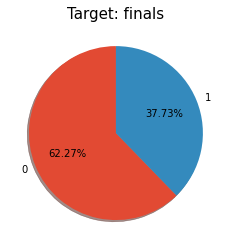

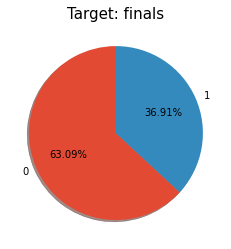

In [225]:
train_label_count = analysis_on_target(train)
test_label_count = analysis_on_target(test)

In [226]:
# 학습셋, 검증셋에서 승리 vs 패배의 비율을 보면 유사하다.
# 이는 기본적으로 8명의 플레이어 중에서 승리할 확률: 3/8 = 0.375, 패배할 확률: 5/8 = 0.625 이기 때문

In [227]:
target = 'finals'
# features = df.columns.drop([target, 'placement', 'units', 'total_damage_to_players', 'players_eliminated'])
features = df.columns.drop([target, 'placement', 'units'])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_true = test[target]

In [136]:
# 타겟, 타겟에 직접적으로 관련이 있는 placement, 전처리를 하지못한 units 을 제외하여 랜덤포레스트모델로 학습시켜보았다.

In [228]:
from sklearn.tree import DecisionTreeClassifier

# 결정트리 분류모델
pipe = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=2, criterion='entropy')
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', pipe.score(X_val, y_val))
print('검증 f1: ', f1_score(y_val, y_pred))

검증 정확도:  0.8534069597832882
검증 f1:  0.8016913319238901


In [229]:
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline

# 랜덤포레스트 분류모델로 모델링
pipe = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_estimators=100, random_state=2, oob_score=True)
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', pipe.score(X_val, y_val))
print('검증 f1: ', f1_score(y_val, y_pred))

검증 정확도:  0.899562408835174
검증 f1:  0.8606936416184972


In [230]:
from xgboost import XGBClassifier

# XGBoost 분류모델
pipe = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=2, learning_rate=0.3, n_jobs=-1)
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', pipe.score(X_val, y_val))
print('검증 f1: ', f1_score(y_val, y_pred))

검증 정확도:  0.9067514065430298
검증 f1:  0.8712785847835466


In [36]:
## 결정트리, 랜덤포레스트, XGBoost 의 간단한 하이퍼파라미터 실행 결과 성능: 결정트리 < 랜덤포레스트 < XGBoost
# 성능이 좋게 나온 XGBoost의 Best 하이퍼파라미터를 찾아서 모델의 성능을 끌어올리자

In [232]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
def fit_trees(X_train, y_train):
    pipe = None    # pipe = make_pipeline(...)
    clf = None     # clf = RandomizedSearchCV(pipe, ...)

    # YOUR CODE HERE

    ## encoder, imputer, 모델을 포함하는 하나의 학습 파이프라인
    pipe = make_pipeline(
        OrdinalEncoder(),
        XGBClassifier(n_estimators=300, random_state=2, n_jobs=-1,)
    )

    ## 적어도 두 개 이상의 하이퍼파라미터
    dists = {
        # 'xgbclassifier__max_depth': [5,10,15,20,None],
        'xgbclassifier__max_features' : uniform(0, 1),
        'xgbclassifier__learning-rate' : [0.1, 0.2, 0.3, 0.4, 0.5]
    }
    ## RandomizedSearchCV
    clf = RandomizedSearchCV(
        pipe, ## 파이프라인
        param_distributions=dists, ## 탐색할 하이퍼파라미터
        n_iter=3, ## n_iter 10회 이하
        cv=4, ## cv 5 이하
        scoring='f1',
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    ## 훈련데이터로 학습
    clf.fit(X_train, y_train)
    # YOUR CODE ENDS HERE

    return clf

In [233]:
clf = fit_trees(X_train, y_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


In [234]:
# CV를 통해 찾은 최적의 하이퍼파라미터를 확인
print("Best CV F1", clf.best_score_)
print("Best CV params", clf.best_params_)

Best CV F1 0.8645797386095196
Best CV params {'xgbclassifier__learning-rate': 0.4, 'xgbclassifier__max_features': 0.9507143064099162}


In [165]:
# F1 score가 0.8645 >> 0.8647로 소폭 상승했다.
# 최적의 하이퍼파라미터를 활용한 XGBoost 모델의 성능을 여러 가지 평가지표로 확인해보자

In [235]:
from sklearn.metrics import classification_report
def predict(X, y, best_estimator):
    y_pred_proba = None

    # YOUR CODE HERE
    y_pred_proba = best_estimator.predict_proba(X)[:,1]
    
    # YOUR CODE ENDS HERE

    report = classification_report(y, y_pred_proba > 0.5)
    return y_pred_proba, report

              precision    recall  f1-score   support

       False       0.92      0.93      0.93      3364
        True       0.88      0.86      0.87      1968

    accuracy                           0.91      5332
   macro avg       0.90      0.90      0.90      5332
weighted avg       0.91      0.91      0.91      5332



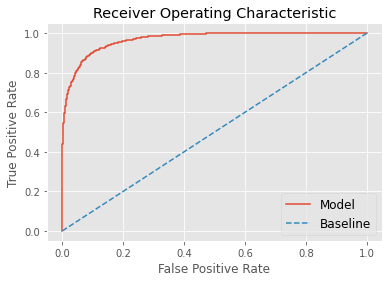

In [236]:
from sklearn.metrics import roc_curve, roc_auc_score

y_test = y_true
def plot_roc(y, y_pred_proba):
    auc_score = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    baseline_fpr, baseline_tpr, _ = roc_curve(y, [0] * len(y))

    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label="Model")
    plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
    plt.xlabel("False Positive Rate", size=12)
    plt.ylabel("True Positive Rate", size=12)
    plt.title("Receiver Operating Characteristic")
    plt.legend(prop={"size": 12})
    plt.show()
    return auc_score


y_test_pred_proba, report = predict(X_test, y_test, clf.best_estimator_)
print(report)
auc_score = plot_roc(y_test, y_test_pred_proba)

In [237]:
print("Test AUC:", auc_score)

Test AUC: 0.9681473130129636


In [238]:
# AUC 스코어 0.968, 생각보다 예측을 잘하고 있다.

In [239]:
pipeline = clf.best_estimator_

# TODO: pipeline을 preprocess_pipeline과 model로 나눠 주세요.
preprocess_pipeline = None
model = None
# YOUR CODE HERE
from sklearn.pipeline import Pipeline
encoder = pipeline.named_steps['ordinalencoder']
model = pipeline.named_steps['xgbclassifier']

pipe = Pipeline([
    ('preprocessing', make_pipeline(encoder)),
    ('xgb', model) 
])

preprocess_pipeline = pipe.named_steps['preprocessing']
model = pipe.named_steps['xgb']

# YOUR CODE ENDS HERE

# TODO: X_test를 preprocess_pipeline에 통과시켜 X_test_preprocessed를 만드세요.
X_test_preprocessed = None
# YOUR CODE HERE
X_test_preprocessed = preprocess_pipeline.transform(X_test)
# YOUR CODE ENDS HERE

In [240]:
import eli5
from eli5.sklearn import PermutationImportance


def get_permutation_importance(X, y, model):
    permuter = None
    # permuter = PermutationImportance(..., n_iter=5, random_state=42)

    # YOUR CODE HERE
    permuter = PermutationImportance(
        pipe.named_steps['xgb'], # model
        scoring='roc_auc', # metric
        n_iter=5, # 다른 random seed를 사용하여 5번 반복
    )
    
    # YOUR CODE ENDS HERE
    permuter.fit(X, y)

    return permuter

In [241]:
permuter = get_permutation_importance(X_test_preprocessed, y_test, model)
eli5.show_weights(permuter, top=None, feature_names=X_test.columns.tolist())
print("Top5 Important Features:")
p_i = sorted(
    list(zip(X_test.columns.tolist(), permuter.feature_importances_)),
    key=lambda x: x[1],
    reverse=True,
)
print(p_i[:5])

Top5 Important Features:
[('total_damage_to_players', 0.21024137387256747), ('players_eliminated', 0.02661384168092573), ('cost_sum', 0.012329072532699104), ('level', 0.005655771777693985), ('high_cost_ratio', 0.0019203057480930985)]


In [52]:
## Feature Importance가 높은 상위 5개 특성: 
# total_damage_to_players (플레이어 본체에 준 피해량, 0~700 까지 가능), 
# players_eliminated (플레이어와 전투 후 상대방 피를 0으로 만든 횟수, 0~7 까지 가능), 
# cost_sum (본인 필드에 배치한 유닛들에 소모된 총 골드), 
# level (본인의 이번 랭크게임에서의 레벨, 필드에 배치 가능한 유닛수와 동일, 기본 1~9 까지 가능하고 증강체에 따라서 10레벨이 가능하다), 
# augment1 (첫번째로 선택한 증강체, 게임 초반에 본인의 플레이 방향을 결정하는 중요한 선택지이다)

# 다른 특성들도 마저 살펴보자

In [242]:
p_i

[('total_damage_to_players', 0.21024137387256747),
 ('players_eliminated', 0.02661384168092573),
 ('cost_sum', 0.012329072532699104),
 ('level', 0.005655771777693985),
 ('high_cost_ratio', 0.0019203057480930985),
 ('main_synergy', 0.0012280162746632906),
 ('augment1', 0.0011816290130795659),
 ('main_synergy_score', 0.0005769481743568949),
 ('total_synergy_score', 0.00042357264387149485),
 ('num_activated_synergy', 0.0001261262241040173),
 ('augment2', -2.8427491468785425e-05),
 ('high_cost_sum', -5.519343986544189e-05),
 ('gold_left', -6.634088338508537e-05),
 ('augment3', -0.00015263538857153148)]

In [174]:
# total_damage_to_players 와 players_eliminated 이 두 특성이 결정적인 이유는, 1위를 할 후보군에 들어갈 만큼 덱이 강력한 경우 자동적으로 따라오는 부산물 특성이기 때문이다.
# 데이터 학습에서 이 두 특성을 지우고 다시 학습해줄 필요성이 있어보인다. (타임라인에 따라 이 시점에 알 수 없는 데이터 이다, 라고는 말할 수 없으나 전투에서 돌아온 비행기에 박힌 총탄 자국과 같은 유형의 예시로 보여진다)
# 즉, 이미 생존경쟁에서 도태되어 결국 4~8위를 기록한 플레이어는 자연히 저 두 특성의 값이 낮을 수 밖에 없다. 이것은 롤토체스 게임에 존재하는 스노우볼 굴리기라고 봐도 무방.
# 이 스노우볼을 제외한 특성으로 재 학습해보자.

In [243]:
target = 'finals'
features = df.columns.drop([target, 'placement', 'units', 'total_damage_to_players', 'players_eliminated'])
# features = df.columns.drop([target, 'placement', 'units'])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_true = test[target]

In [244]:
from sklearn.tree import DecisionTreeClassifier

# 결정트리 분류모델
pipe = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=2, criterion='entropy')
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', pipe.score(X_val, y_val))
print('검증 f1: ', f1_score(y_val, y_pred))

검증 정확도:  0.7600541779537404
검증 f1:  0.6790243902439024


In [245]:
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline

# 랜덤포레스트 분류모델
pipe = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', pipe.score(X_val, y_val))
print('검증 f1: ', f1_score(y_val, y_pred))

검증 정확도:  0.824650968951865
검증 f1:  0.7539833357696243


In [246]:
from xgboost import XGBClassifier

# XGBoost 분류모델
pipe = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', pipe.score(X_val, y_val))
print('검증 f1: ', f1_score(y_val, y_pred))

검증 정확도:  0.8282975619920817
검증 f1:  0.7593457943925235


In [59]:
# 기본 하이퍼파라미터로 돌린 성능: 결정트리 < 랜덤포레스트 < XGBoost
# CV를 통해 XGBoost의 Best 하이퍼파라미터를 찾아보자.

In [249]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
def fit_trees(X_train, y_train):
    pipe = None    # pipe = make_pipeline(...)
    clf = None     # clf = RandomizedSearchCV(pipe, ...)

    # YOUR CODE HERE

    ## encoder, imputer, 모델을 포함하는 하나의 학습 파이프라인
    pipe = make_pipeline(
        OrdinalEncoder(),
        XGBClassifier(n_estimators=1000, random_state=2, n_jobs=-1,)
    )

    ## 적어도 두 개 이상의 하이퍼파라미터
    dists = {
        # 'xgbclassifier__max_depth': [5,10,15,20,None],
        'xgbclassifier__max_features' : uniform(0, 1),
        'xgbclassifier__learning-rate' : [0.1, 0.2, 0.3, 0.4, 0.5]
    }
    ## RandomizedSearchCV
    clf = RandomizedSearchCV(
        pipe, ## 파이프라인
        param_distributions=dists, ## 탐색할 하이퍼파라미터
        n_iter=5, ## n_iter 10회 이하
        cv=4, ## cv 5 이하
        scoring='f1',
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    ## 훈련데이터로 학습
    clf.fit(X_train, y_train)
    # YOUR CODE ENDS HERE

    return clf

In [250]:
clf = fit_trees(X_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


In [251]:
print("Best CV F1", clf.best_score_)
print("Best CV params", clf.best_params_)

Best CV F1 0.7675904037423953
Best CV params {'xgbclassifier__learning-rate': 0.4, 'xgbclassifier__max_features': 0.9507143064099162}


              precision    recall  f1-score   support

       False       0.86      0.88      0.87      3364
        True       0.79      0.75      0.77      1968

    accuracy                           0.83      5332
   macro avg       0.82      0.82      0.82      5332
weighted avg       0.83      0.83      0.83      5332



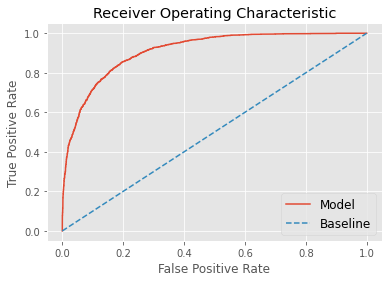

In [252]:
y_test = y_true
y_test_pred_proba, report = predict(X_test, y_test, clf.best_estimator_)
print(report)
auc_score = plot_roc(y_test, y_test_pred_proba)

In [253]:
print("Test AUC:", auc_score)

Test AUC: 0.9109097220208231


In [254]:
pipeline = clf.best_estimator_

# TODO: pipeline을 preprocess_pipeline과 model로 나눠 주세요.
preprocess_pipeline = None
model = None
# YOUR CODE HERE
from sklearn.pipeline import Pipeline
encoder = pipeline.named_steps['ordinalencoder']
model = pipeline.named_steps['xgbclassifier']

pipe = Pipeline([
    ('preprocessing', make_pipeline(encoder)),
    ('xgb', model) 
])

preprocess_pipeline = pipe.named_steps['preprocessing']
model = pipe.named_steps['xgb']

# YOUR CODE ENDS HERE

# TODO: X_test를 preprocess_pipeline에 통과시켜 X_test_preprocessed를 만드세요.
X_test_preprocessed = None
# YOUR CODE HERE
X_test_preprocessed = preprocess_pipeline.transform(X_test)
# YOUR CODE ENDS HERE

In [255]:
permuter = get_permutation_importance(X_test_preprocessed, y_test, model)
eli5.show_weights(permuter, top=None, feature_names=X_test.columns.tolist())
print("Top5 Important Features:")
p_i = sorted(
    list(zip(X_test.columns.tolist(), permuter.feature_importances_)),
    key=lambda x: x[1],
    reverse=True,
)
print(p_i[:5])

Top5 Important Features:
[('cost_sum', 0.2751878298918245), ('level', 0.08868303377222246), ('main_synergy', 0.015053640652339984), ('total_synergy_score', 0.01336886618717561), ('high_cost_ratio', 0.011355438502363624)]


In [67]:
## Feature Importance가 높은 상위 5개 특성: 
# cost_sum (본인 필드에 배치한 유닛들에 소모된 총 골드), 
# level (본인의 이번 랭크게임에서의 레벨, 필드에 배치 가능한 유닛수와 동일, 기본 1~9 까지 가능하고 증강체에 따라서 10레벨이 가능하다), 
# main_synergy (본인이 선택하여 가장 많은 유닛을 배치한 시너지 종류)
# high_cost_ratio (4코스트 이상의 고급기물 배치에 소모한 골드 / 전체 필드 배치에 소모한 골드, 코스트 높은 유닛의 영향력이라고 볼수 있다.)
# total_synergy_score (본인이 배치한 시너지와 해당 시너지의 유닛수를 곱한 각각의 시너지점수의 총합)

# 다른 특성들도 마저 살펴보자

In [256]:
p_i

[('cost_sum', 0.2751878298918245),
 ('level', 0.08868303377222246),
 ('main_synergy', 0.015053640652339984),
 ('total_synergy_score', 0.01336886618717561),
 ('high_cost_ratio', 0.011355438502363624),
 ('augment1', 0.006284016318165664),
 ('main_synergy_score', 0.0054986351178911265),
 ('augment2', 0.005452338485929497),
 ('high_cost_sum', 0.00314805013389019),
 ('gold_left', 0.0023179130052299437),
 ('augment3', 0.0014007412294694266),
 ('num_activated_synergy', 0.0007320456676624509)]

In [187]:
# 전체적으로 0.001 이상의 특성중요도를 기록했다
# pdp plot을 통해 특성별, 특성간의 관계를 시각화해보자

In [257]:
from pdpbox.pdp import pdp_isolate, pdp_plot


def get_pdp_isolated(dataset, model, feature):
    pdp_isolated = None

    # YOUR CODE HERE
    pdp_isolated = pdp_isolate(
        model=model, 
        dataset=dataset, 
        model_features=dataset.columns, 
        feature=feature,
        grid_type='percentile', # default='percentile', or 'equal'
        num_grid_points=50 # default=10
    )
    
    # YOUR CODE ENDS HERE

    return pdp_isolated

In [258]:
sorted(p_i, key=lambda x: x[1], reverse=True)

[('cost_sum', 0.2751878298918245),
 ('level', 0.08868303377222246),
 ('main_synergy', 0.015053640652339984),
 ('total_synergy_score', 0.01336886618717561),
 ('high_cost_ratio', 0.011355438502363624),
 ('augment1', 0.006284016318165664),
 ('main_synergy_score', 0.0054986351178911265),
 ('augment2', 0.005452338485929497),
 ('high_cost_sum', 0.00314805013389019),
 ('gold_left', 0.0023179130052299437),
 ('augment3', 0.0014007412294694266),
 ('num_activated_synergy', 0.0007320456676624509)]

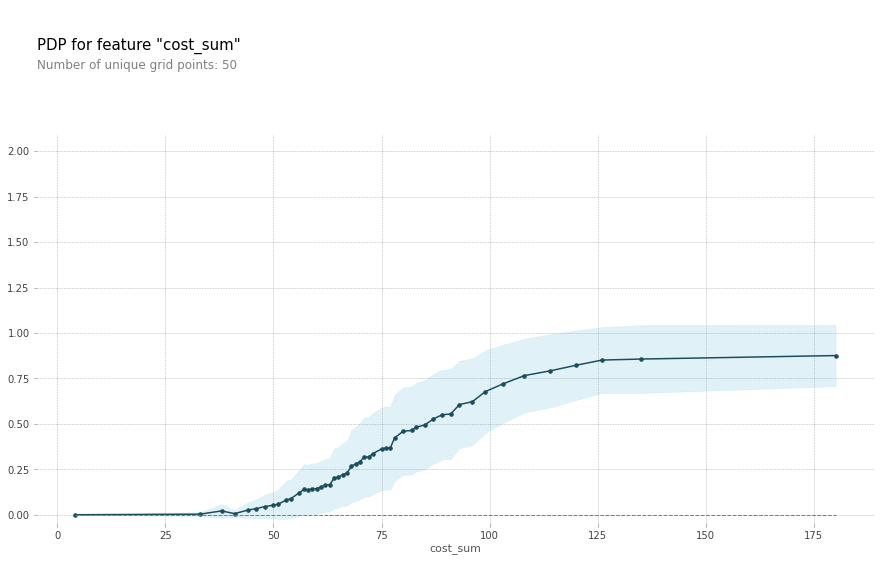

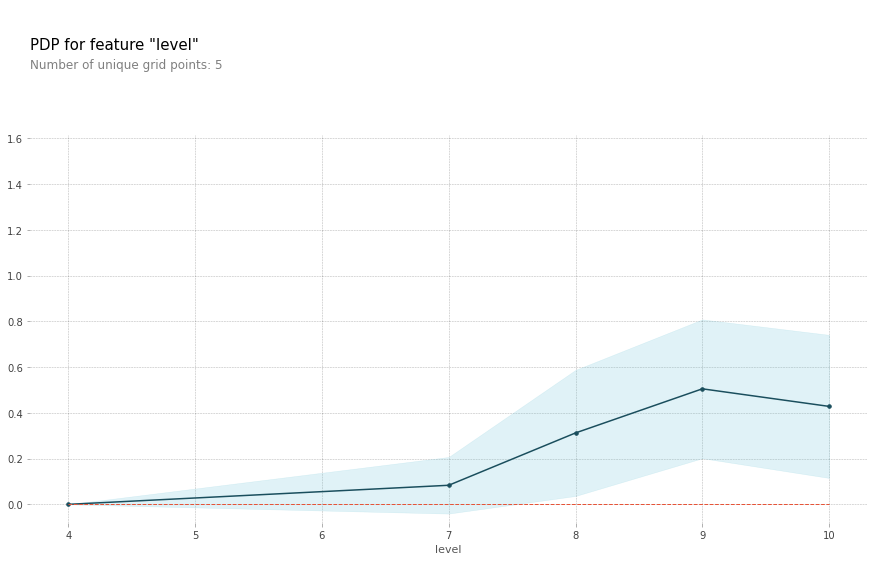

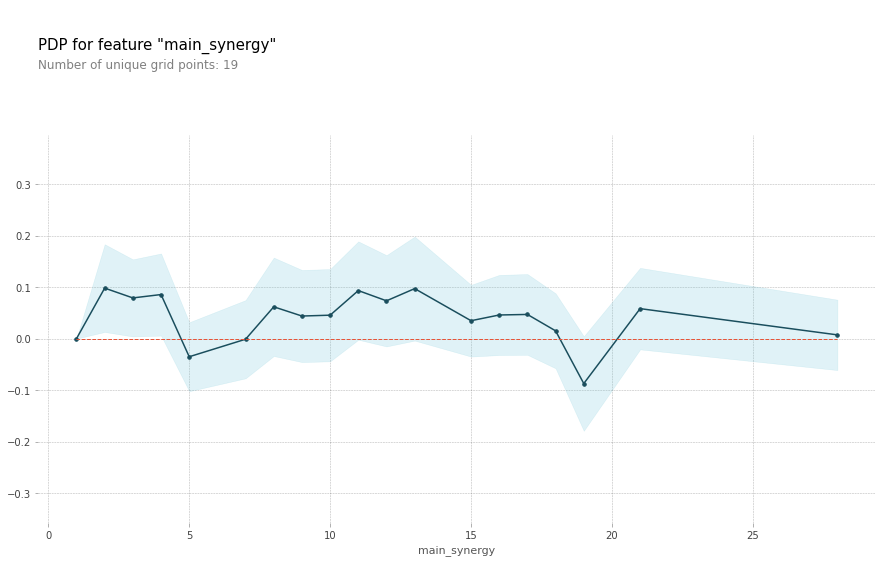

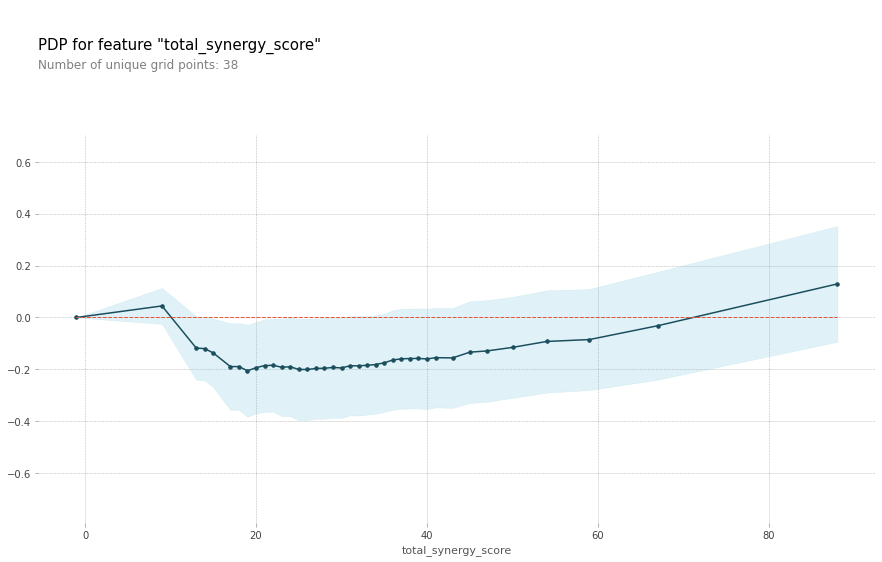

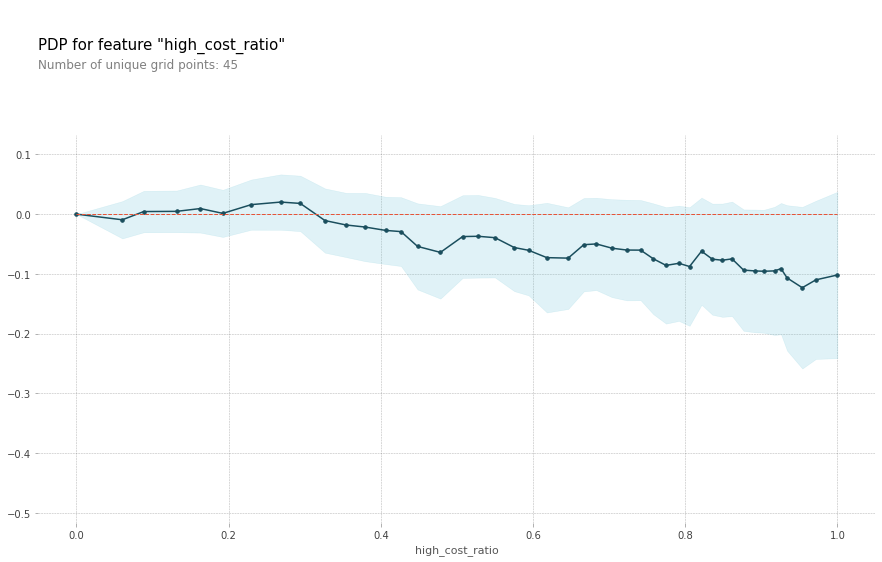

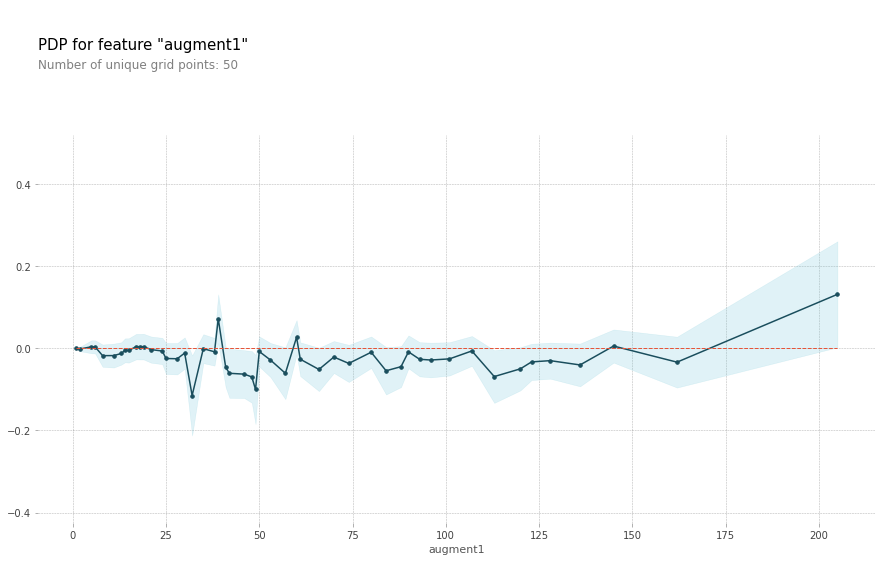

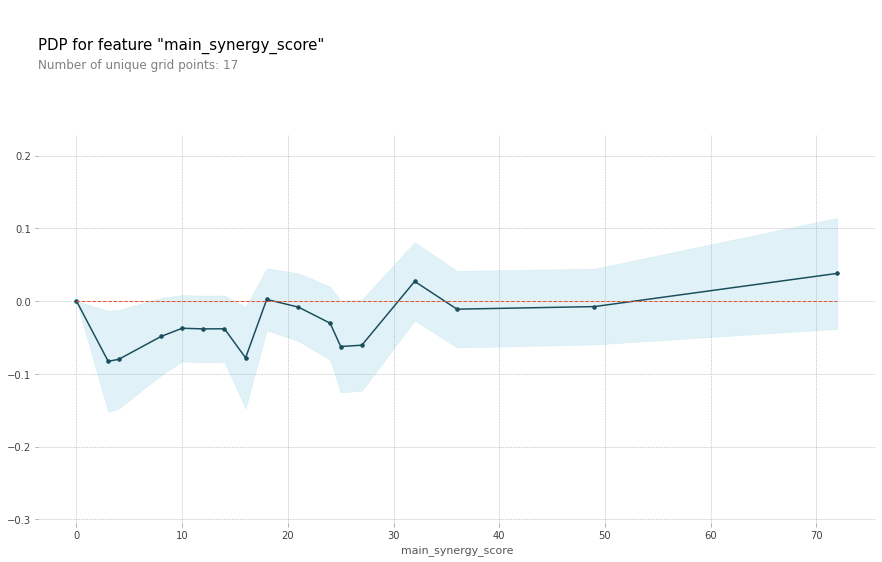

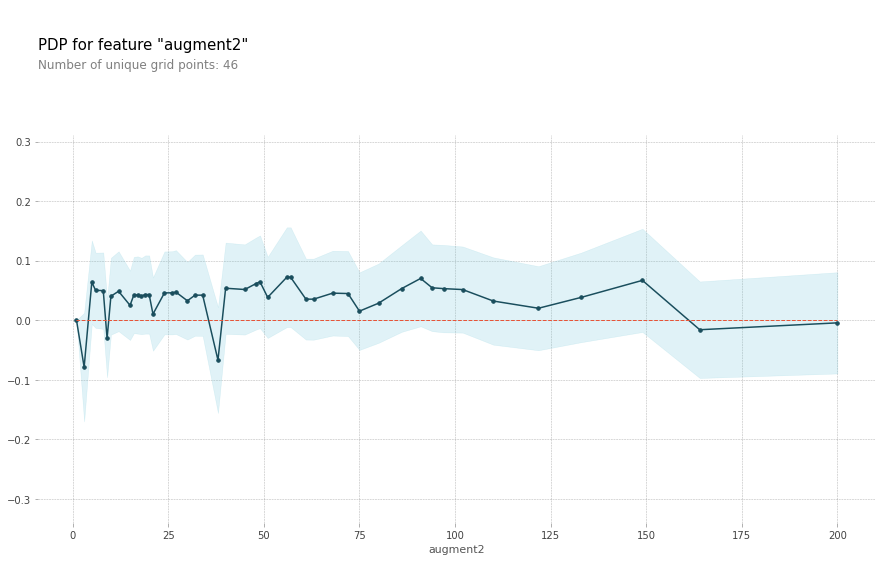

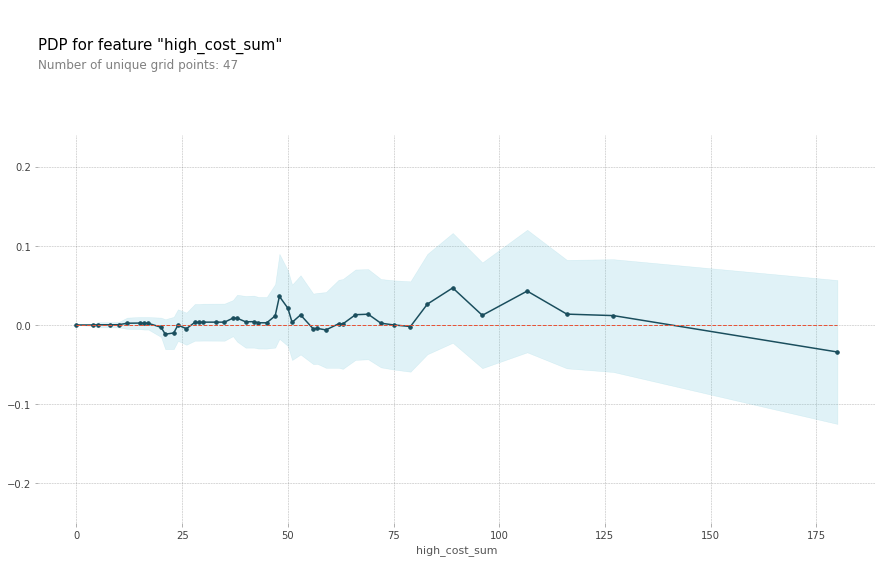

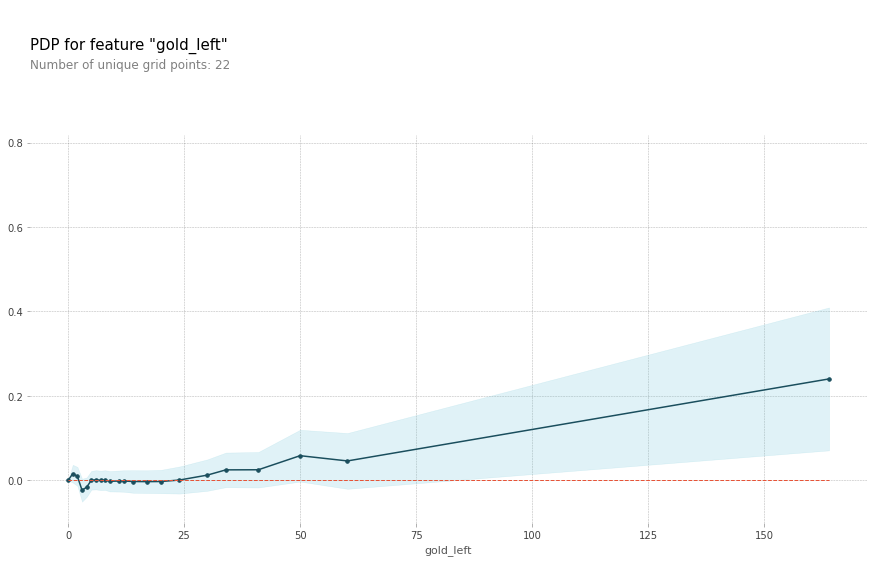

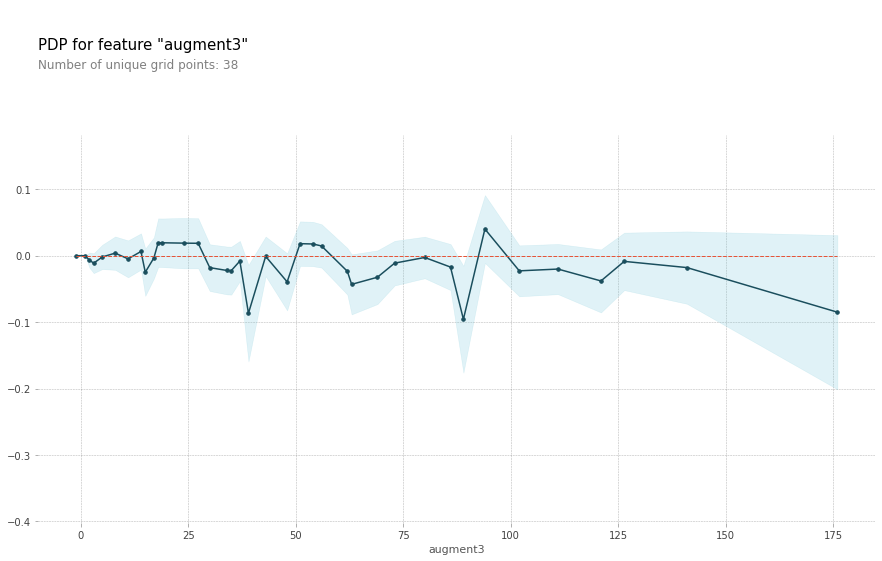

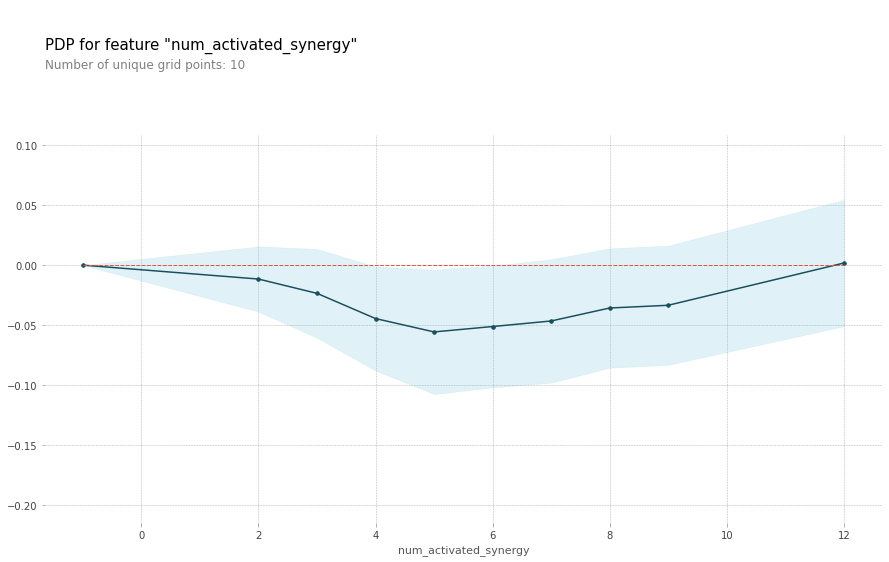

In [259]:
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=X_test.columns)
# sorted() 는 특성중요도 p_i를 중요도가 높은 순서로 정렬한 Series
# 각 특성을 보려면 뒤 인덱스를 조절해주면 된다.
for i in range(0, len(p_i)):
    feature = sorted(p_i, key=lambda x: x[1], reverse=True)[i][0]
    pdp_isolated = get_pdp_isolated(X_test_preprocessed_df, model, feature)
    pdp_plot(pdp_isolated, feature_name=feature)

In [260]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

def get_pdp_interaction(dataset, model, features):
    pdp_interaction = None

    # YOUR CODE HERE
    pdp_interaction = pdp_interact(
        model = model, 
        dataset = dataset,
        model_features = dataset.columns, 
        features = features
    )
    
    # YOUR CODE ENDS HERE

    return pdp_interaction

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f454638a130>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f45449cf940>})

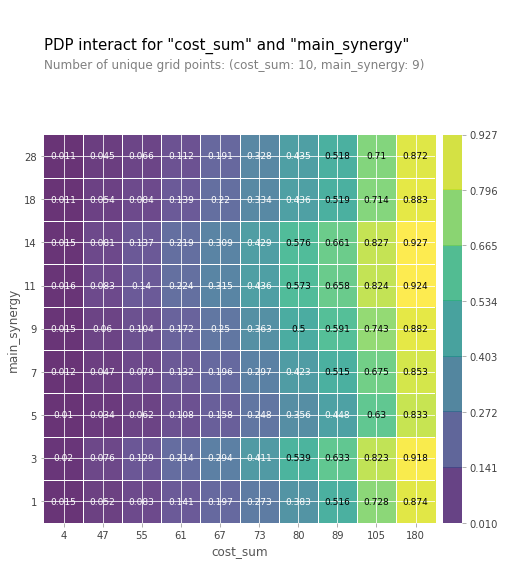

In [261]:
# features = list(map(lambda x: x[0], sorted(p_i, key=lambda x: x[1], reverse=True)))[:2]
features = ['cost_sum','main_synergy']
pdp_interaction = get_pdp_interaction(X_test_preprocessed_df, model, features)
pdp_interact_plot(pdp_interaction, feature_names=features, plot_type="grid")

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4546217100>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f454622e7c0>})

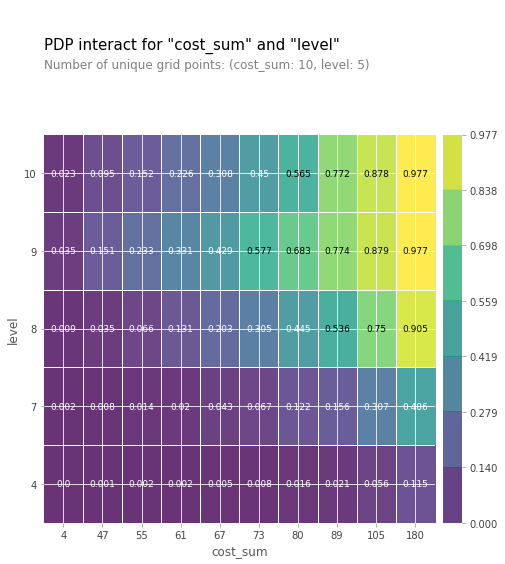

In [263]:
features = ['cost_sum','level']
pdp_interaction = get_pdp_interaction(X_test_preprocessed_df, model, features)
pdp_interact_plot(pdp_interaction, feature_names=features, plot_type="grid")

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f45460c30d0>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f454612c3a0>})

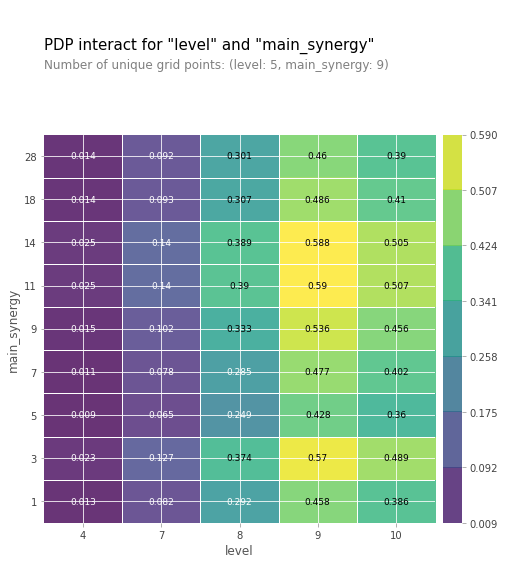

In [264]:
features = ['level','main_synergy']
pdp_interaction = get_pdp_interaction(X_test_preprocessed_df, model, features)
pdp_interact_plot(pdp_interaction, feature_names=features, plot_type="grid")

In [265]:
encoder

OrdinalEncoder(cols=['augment1', 'augment2', 'augment3', 'main_synergy'],
               mapping=[{'col': 'augment1', 'data_type': dtype('O'),
                         'mapping': BlueBattery1             1
Ascension                2
Electrocharge3           3
ShimmerscaleEmblem       4
MeleeStarBlade2          5
                      ... 
Meditation2            203
GuildLootHR            204
TargetDummies          205
DragonmancerInspire    206
NaN                     -2
Length: 207, dtype: int64},
                        {'col': 'augment2', 'data_type': dtype('O'),
                         'mapping...
Length: 187, dtype: int64},
                        {'col': 'main_synergy', 'data_type': dtype('O'),
                         'mapping': Astral           1
Scalescorn       2
Lagoon           3
Darkflight       4
Dragon           5
Cavalier         6
Mage             7
Cannoneer        8
Guardian         9
Guild           10
Jade            11
Mystic          12
Warrior         13
Swifts

In [268]:
## main_synergy
# 28 : 형상변환자
# 18 : 분노날개
# 14 : 민첩사수
# 11 : 비취
# 9 : 수호자
# 7 : 요술사
# 5 : 용
# 3 : 석호
# 1 : 별
## -> 9 레벨을 찍었다면 가장 승률이 좋은 메인시너지는 비취와 민첩사수, 석호 이다. 
## -> 주목할만한 점은 형상변환자, 챌린저 전체 게임데이터에서 0.2% 의 챌린저 유저만이 메인으로 선택했는데 승률 상위 9개 시너지에 포함되어있다.
# 형상변환자의 주 딜러 챔피언은 쉬바나(10 코스트), 보조 챔피언은 제이스(4코스트)로 상당히 고코스트의 기물을 필요로한다.

In [267]:
df.main_synergy.value_counts(normalize=True)

Lagoon          0.134457
Dragon          0.133257
Jade            0.094959
Guild           0.079185
Guardian        0.074571
Astral          0.063337
Dragonmancer    0.050771
Ragewing        0.045632
Darkflight      0.043944
Cannoneer       0.043569
Mirage          0.040962
Scalescorn      0.038167
Shimmerscale    0.036742
Mage            0.027570
Warrior         0.021025
Whispers        0.015398
Swiftshot       0.010409
Cavalier        0.008796
Mystic          0.008721
Assassin        0.008384
Tempest         0.006714
Evoker          0.005514
Bruiser         0.003845
Monolith        0.002588
None            0.000675
Bard            0.000544
Shapeshifter    0.000206
Prodigy         0.000056
Name: main_synergy, dtype: float64

In [262]:
encoder

OrdinalEncoder(cols=['augment1', 'augment2', 'augment3', 'main_synergy'],
               mapping=[{'col': 'augment1', 'data_type': dtype('O'),
                         'mapping': BlueBattery1             1
Ascension                2
Electrocharge3           3
ShimmerscaleEmblem       4
MeleeStarBlade2          5
                      ... 
Meditation2            203
GuildLootHR            204
TargetDummies          205
DragonmancerInspire    206
NaN                     -2
Length: 207, dtype: int64},
                        {'col': 'augment2', 'data_type': dtype('O'),
                         'mapping...
Length: 187, dtype: int64},
                        {'col': 'main_synergy', 'data_type': dtype('O'),
                         'mapping': Astral           1
Scalescorn       2
Lagoon           3
Darkflight       4
Dragon           5
Cavalier         6
Mage             7
Cannoneer        8
Guardian         9
Guild           10
Jade            11
Mystic          12
Warrior         13
Swifts

In [269]:
# 테스트셋 예측 결과 계산하는 함수
def calculate_score(pipe, X_test, y_test):
    test_accuracy = pipe.score(X_test, y_test)
    test_f1 = f1_score(y_test, pipe.predict(X_test))
    return test_accuracy, test_f1

In [270]:
test_accuracy, test_f1 = calculate_score(clf.best_estimator_, X_test, y_test)

In [271]:
print("test accuracy: ", test_accuracy)
print("test F1:", test_f1)

test accuracy:  0.8338334583645911
test F1: 0.7691505992704535


In [272]:
# 레벨이 높을수록, 전체 덱에 들어간 골드가 비쌀수록 3위안에 들 확률이 높다.
# 리롤덱이라고하여 낮은 코스트 유닛을 9마리씩 모아서 중반부터 강하게 올라가는 덱이 있는데, 그것보다는 전체 코스트가 높은 덱이 유리한 것으로 보임.(유닛은 운빨이 조금 있음)
# 전체 cost가  10레벨보다 9레벨에서 승률이 미세하게 높다.
# 

In [273]:
# 고코스트 기물의 비중이 낮은데 전체 비용은 높은 경우, 즉 3코스트 이하 기물을 3성작을 하여 시너지를 많이 채우는 경우가 승률이 좋다.
# -> 높은 코스트의 유닛을 기대하고 무작정 레벨업을 하는 것이 아닌, 적절히 낮은 코스트의 유닛이 잘 나오는 상점을 reload 하여 3성작을 맞춰가는 플레이를 선택하는 것이 좋다.

In [274]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 5.2 MB/s 


In [275]:
import shap

 99%|===================| 5272/5332 [01:02<00:00]       

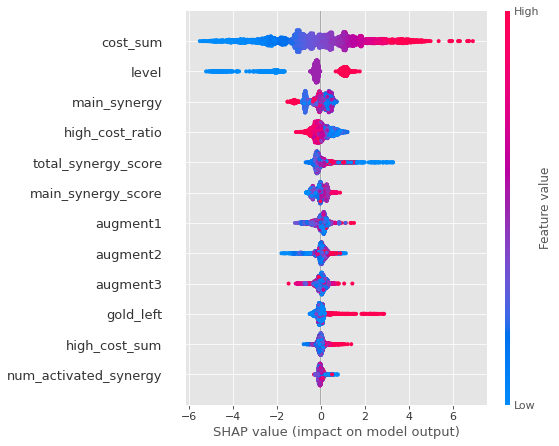

In [278]:
shap.initjs()
explainer = shap.Explainer(model, X_test_preprocessed)
shap_values = explainer(X_test_preprocessed)
shap.summary_plot(shap_values)

In [282]:
df.groupby('main_synergy')['placement'].mean().sort_values()

main_synergy
Bard            2.206897
Dragon          3.786207
Mystic          3.793548
Warrior         3.853702
Monolith        3.913043
Swiftshot       4.218018
Dragonmancer    4.274474
Jade            4.317993
Mage            4.353061
Assassin        4.380313
Ragewing        4.391697
Scalescorn      4.501229
Tempest         4.547486
Cannoneer       4.549290
Evoker          4.632653
Darkflight      4.682458
Guild           4.694458
Mirage          4.782967
Astral          4.801599
Whispers        4.833130
Lagoon          4.845167
Guardian        4.859658
Cavalier        4.863539
Shimmerscale    5.015314
Bruiser         5.234146
None            5.277778
Shapeshifter    5.818182
Prodigy         6.666667
Name: placement, dtype: float64

In [288]:
X_test_preprocessed.sort_values('cost_sum', ascending = False)

,augment1,augment2,augment3,level,gold_left,main_synergy,main_synergy_score,total_synergy_score,num_activated_synergy,cost_sum,high_cost_sum,high_cost_ratio
8613,30,30,1.0,9,4,1,3,10,3,180.0,180,1.000000
48700,63,26,70.0,9,27,19,36,45,8,177.0,165,0.932203
50014,20,17,11.0,9,30,5,16,31,8,171.0,171,1.000000
50083,178,18,65.0,9,1,9,18,38,7,167.0,152,0.910180
49587,49,9,3.0,9,23,5,16,38,8,165.0,156,0.945455
...,...,...,...,...,...,...,...,...,...,...,...,...
10723,146,69,28.0,5,104,1,0,0,0,7.0,0,0.000000
40553,38,22,28.0,5,135,14,2,2,1,7.0,4,0.571429
10820,68,20,28.0,5,107,17,0,0,0,7.0,0,0.000000
51229,93,123,28.0,5,103,17,0,0,0,5.0,0,0.000000


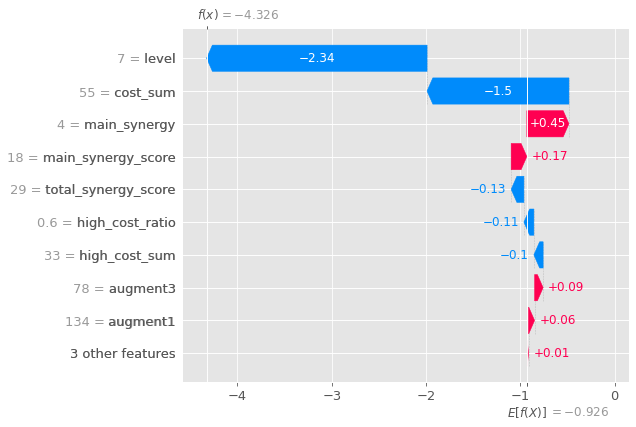

In [293]:
shap.plots.waterfall(shap_values[-1])

In [294]:
shap.initjs()
shap.force_plot(shap_values[-1])